# Import packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from datetime import date

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer,recall_score, accuracy_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

import nltk
from nltk.stem import WordNetLemmatizer
import re
nltk.download('wordnet')
nltk.download("stopwords")

/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/polinaminkovski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/polinaminkovski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pip install thefuzz

In [2]:
from thefuzz import fuzz
from thefuzz import process

In [ ]:
pip install google-api-python-client

In [ ]:
pip install youtube_transcript_api

In [ ]:
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi

In [ ]:
pip install scrapetube

In [3]:
import pickle

In [ ]:
import scrapetube

# Setup for API

### Scrape Playlist (Colbert Questionnert)

In [ ]:
#code support from stackoverflow user - José Angel Bernal
#pull all the titles and transcripts from the playlist (once/if playlist is created)

#1.query API

rq = build("youtube", "v3", developerKey=api_key).playlistItems().list(
        part="contentDetails, snippet",
        playlistId="PLiZxWe0ejyv_wVOeoEO7tjHq-GZg_GGqK",
        maxResults=45,
        ).execute()

#2.Create a list with video Ids and Titles

vid_ids = []
vid_title = []
for item in rq["items"]:
    vid_ids.append(item["contentDetails"]["videoId"])
    vid_title.append(item["snippet"]["title"])

#3.Get transcripts

srt = YouTubeTranscriptApi.get_transcripts(vid_ids)

#4.For each video id extract the Key:"text" from a list of dictionaries

for i in vid_ids:
    get_key_text = [" ".join([a_dict["text"] for a_dict in srt[0][i]]) for i in vid_ids]

#5.Create a dictionary with the title and transcript for each video id

pl_dict = dict(zip(vid_title,get_key_text))

#6.print trancript under title

#for key, value in pl_dict.items():
#    print(key,"\n", value)

#7. create list of tuples of titles and transcripts
pl_list = list(zip(vid_title,get_key_text))

In [ ]:
pl_df = pd.DataFrame(pl_list, columns = ["title", "transcipt"])

In [ ]:
pl_df.to_csv("questions_transcript.csv") #transcripts saved for all questionnert videos in the playlist

In [ ]:
transcripts_playlist = pd.read_csv('questions_transcript.csv')

In [ ]:
separator = " Takes"
transcripts_playlist[["title_tail_1","title_tail_2"]] = transcripts_playlist["title"].str.split(separator,expand=True)

### Scrape Channel (The Late Show With Stephen Colbert)

### Getting all the Video IDs from the Channel

In [ ]:
list_of_vids=[]
dataframe = pd.DataFrame(columns = ["vid_id"])
videos=scrapetube.get_channel("UCMtFAi84ehTSYSE9XoHefig")
for video in videos:
  vidid1 = str(video['videoId'])
  list_of_vids.append(vidid1)
dataframe['vid_id']=list_of_vids
dataframe

In [ ]:
dataframe.to_csv("all_vidids.csv") #saving to CSV to not run this again

In [ ]:
dataframe = pd.read_csv("all_vidids.csv", index_col=[0])

In [ ]:
list_of_vids = list(dataframe['vid_id'])

### Testing out the transcript API

In [ ]:
#get transcripts for all vid IDs, and skip videos where transcripts are disabled
srt_all = []
for vid_id in list_of_vids:
    try:
        srt_all += [YouTubeTranscriptApi.get_transcripts([vid_id])]
    except:
        srt_all += [({vid_id == []}, [])]

In [ ]:
with open('transcripts_all.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(srt_all, file)

In [ ]:
file = open("transcripts_all.pkl",'rb')
object_file = pickle.load(file)

In [ ]:
#organize transcripts by Video ID
get_key_text_all = []
for video in object_file: #i in range(len(vid_ids_all_unique)):
  if len(video) == 0 or type(video[0]) is not dict: continue

  list_of_list_of_content_dicts = list(video[0].values())
  if type(list_of_list_of_content_dicts) is not list: continue

  transcript_ = []
  for list_of_content_dict in list_of_list_of_content_dicts:
    for content_dict in list_of_content_dict:
      transcript_.append(content_dict["text"])
      transcript_string = " ".join(transcript_)
    get_key_text_all.append(transcript_string)

#5.Create a dictionary with the title and transcript for each video id

pl_dict_all = dict(zip(list_of_vids, get_key_text_all))

#6.print trancript under title

#for key, value in pl_dict.items():
#    print(key,"\n", value)

#7. create list of tuples of titles and transcripts
pl_list_all = list(zip(list_of_vids,get_key_text_all))

In [ ]:
with open('colbert_transcripts_processed.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(pl_dict_all, file)

In [ ]:
file = open("colbert_transcripts_processed.pkl",'rb')
colbert_transcripts_processed = pickle.load(file)

### Running the full Scrape (1000 entries at a time)

In [ ]:
url_dem = "https://raw.githubusercontent.com/polinamin/colbert_report/main/all_vidids.csv"
dataframe = pd.read_csv(url_dem, low_memory=False)

In [ ]:
list_of_vids = list(dataframe['vid_id'])

In [ ]:
list_of_vids[100]

In [ ]:
video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id="KmOn6LomXd0"
        ).execute()
video_details['itmes']

In [ ]:
#build title, id, date reference df (entries 0-999)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[0:1000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})


In [ ]:
#build title, id, date reference df (entries 0-999) - get viewing statistics
ids, views, likes, comments, durations = [], [], [], [], []
for vidid in list_of_vids[0]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="statistics, contentDetails",
        id=vidid
        ).execute()
  print(video_details)

  id=video_details['items'][0]['id']
  view=video_details['items'][0]['statistics']["viewCount"]
  like=video_details['items'][0]['statistics']["likeCount"]
  comment=video_details['items'][0]['statistics']["commentCount"]
  duration=video_details['items'][0]['contentDetails']["duration"]

  ids.append(id)
  views.append(view)
  likes.append(like)
  comments.append(comment)
  durations.append(duration)

vid_details_df_stats = pd.DataFrame({'video_id': ids, 'video_views': views, 'video_likes': likes, 'video_comments': comments, 'video_duration': duratinos})

In [ ]:
#build title, id, date reference df (entries 1001-2000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[1000:2000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_1 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})


In [ ]:
#build title, id, date reference df (entries 2000-3000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[2000:3000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_2 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})


In [ ]:
#build title, id, date reference df (entries 3000-4000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[3000:4000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_3 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})


In [ ]:
#build title, id, date reference df (entries 4000-5000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[4000:5000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_4 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})


In [ ]:
#build title, id, date reference df (entries 5000-6000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[5000:6000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_5 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})


In [ ]:
#build title, id, date reference df (entries 6000-7000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[6000:7000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_6 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})


In [ ]:
#build title, id, date reference df (entries 7000-8000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[7000:8000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_7 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})


In [ ]:
#build title, id, date reference df (entries 8000-9000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[8000:9000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_8 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})

In [ ]:
#build title, id, date reference df (entries 9000-10000)
ids, titles, dates, descriptions = [], [], [], []
for vidid in list_of_vids[9000:10000]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']


  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_9 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})

In [ ]:
#build title, id, date reference df (entries 10000-10658)
ids, titles, dates, descriptions = [], [], [], []

for vidid in list_of_vids[10000:(len(list_of_vids)+1)]:
  video_details = build("youtube", "v3", developerKey=api_key).videos().list(
        part="contentDetails, snippet",
        id=vidid
        ).execute()
  id=video_details['items'][0]['id']
  title=video_details['items'][0]['snippet']['title']
  date=video_details['items'][0]['snippet']['publishedAt']
  description=video_details['items'][0]['snippet']['description']

  ids.append(id)
  titles.append(title)
  dates.append(date)
  descriptions.append(description)

vid_details_df_10 = pd.DataFrame({'video_title': titles, 'video_id': ids, 'published_date': dates, 'description': descriptions})

In [ ]:
#consolidate into a single df with all the video details and save to csv
vid_details_df_final = vid_details_df.append([vid_details_df_1,
                                              vid_details_df_2,
                                              vid_details_df_3,
                                              vid_details_df_4,
                                              vid_details_df_5,
                                              vid_details_df_6,
                                              vid_details_df_7,
                                              vid_details_df_8,
                                              vid_details_df_9,
                                              vid_details_df_10], ignore_index=True)
vid_details_df_final.to_csv("vidid_reference.csv")


In [ ]:
#full dataframe with video IDs and information
colbert_df = pd.merge(left = dataframe, right = vid_details_df_final, left_on = "vid_id", right_on = "video_id", how = "left")

In [ ]:
colbert_df.head(2)

In [ ]:
#create df with transcripts
transcript_list = []
for i in colbert_df["vid_id"]:
  transcript_list.append(i, colbert_transcripts_processed[i])

In [ ]:
for i in colbert_df.vid_id:
  for j in colbert_transcripts_processed:
    if i == j:
      colbert_df.loc[colbert_df.vid_id == j, "transcripts"] = colbert_transcripts_processed[j]


In [ ]:
#colbert_df.to_csv("all_data_colbert.csv")

In [ ]:
import pandas as pd

In [ ]:
colbert_df = pd.read_csv("all_data_colbert.csv", index_col=[0])

In [ ]:
colbert_df.shape

In [ ]:
colbert_df.head(2)

### Looking at Celebrity Demographics



In [ ]:
celebrity_reference = pd.read_csv("Colbert Questionert - Sheet4.csv")

In [ ]:
celebrities = celebrity_reference.drop_duplicates()

In [ ]:
#create name hashtags
celebrities["hash_name"] = "#"+celebrities["Guest(s)"].str.replace(" ", "")

In [ ]:
celebrities.shape

In [ ]:
colbert_df.dropna(inplace=True)

In [ ]:
genders = []
occuptions = []
for i, v in colbert_df.iterrows():
  for j, r in celebrities.iterrows():
    if (r["hash_name"] in v['description']) and (r["Guest(s)"] in v['video_title']) or (r["Guest(s)"] in v['transcripts'][:200]):
      genders.append((v['video_title'],r["Guest(s)"],r["Gender"], r["Occupation"]))
genders_ = pd.DataFrame(genders, columns = ["video_title", "Name", "gender", "occupation"])
colbert_df = pd.merge(left = colbert_df, right = genders_, left_on = "video_title", right_on = "video_title", how = "left")

In [ ]:
#data count for analysis (# of matches)
colbert_df.shape[0] - max(colbert_df.isna().sum())

In [ ]:
celebrities[celebrities["Guest(s)"]=="Matt Damon"]

In [ ]:
colbert_df.to_csv("final_dataset.csv")

In [ ]:
colbert_df.drop(columns=["Name", "gender", "occupation"], inplace=True)
colbert_df.isna().sum()

### Celebrity Demographics for Questionnert Subset

In [ ]:
genders = []
occuptions = []
for i, v in transcripts_playlist.iterrows():
  for j, r in celebrities.iterrows():
    if v['title_tail_1'] in r["Guest(s)"]:
      genders.append((v['title_tail_1'],r["Gender"], r["Occupation"]))
genders_ = pd.DataFrame(genders, columns = ["Name", "gender", "occupation"])
transcripts_playlist = pd.merge(left = transcripts_playlist, right = genders_, left_on = "title_tail_1", right_on = "Name", how = "left")

In [ ]:
transcripts_playlist.drop_duplicates(subset = ["title"], inplace=True)

In [ ]:
transcripts_playlist[transcripts_playlist["occupation"].isna()]

In [ ]:
transcripts_playlist.loc[0,"gender"]= "Male"
transcripts_playlist.loc[33,"gender"]= "Male"
transcripts_playlist.loc[38,"gender"]= "Female"
transcripts_playlist.loc[42,"gender"]= "Male"
transcripts_playlist.loc[48,"gender"]= "Male"
transcripts_playlist.loc[49,"gender"]= "Male"
#transcripts_playlist.loc[51,"gender"]= "Male"
transcripts_playlist.loc[52,"gender"]= "Male"
transcripts_playlist.loc[63,"gender"]= "Male"

In [ ]:
transcripts_playlist.loc[0,"occupation"]= "Musician"
transcripts_playlist.loc[48,"occupation"]= "Host"
transcripts_playlist.loc[49,"occupation"]= "Host"
#transcripts_playlist.loc[51,"occupation"]= "Musician"

In [ ]:
transcripts_playlist.loc[51,"title_tail_1"] = "Tiffany Haddish"
transcripts_playlist.loc[51,"gender"] = "Female"
transcripts_playlist.loc[51,"Occupation"] = "Comedian"

In [ ]:
transcripts_playlist.drop([61], inplace=True)

In [ ]:
transcripts_playlist["gender"].value_counts(normalize=True)

In [ ]:
transcripts_playlist["occupation"].value_counts(normalize=True)

# Predicting role based on transcripts (Trying some models)

In [ ]:
#let's remove duplicate video IDs. We will keep multi part guests as separate entries
#will do additional analysis on combined guests and word counts by gender/occupation/age as a separate analysis (will need to create a different df)

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('wordnet')

In [ ]:
nltk.download("stopwords")

In [ ]:
#stopwords
stops = nltk.corpus.stopwords.words('english')
newStopWords = ['applause','back','welcome','stephen','everybody','break','cheering','colbert']
stops.extend(newStopWords)

In [ ]:
#create lemmatized text

def text_process(text):
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()

  words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1) and (type(x) == str)]
  sentence = " ".join(words)
  splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
  list_of_sentences = " ".join(splits)

  return list_of_sentences

In [ ]:
#filter out nulls
colbert_df_filtered = colbert_df.dropna()

In [ ]:
colbert_df_filtered["revised_transcripts"]=colbert_df_filtered["transcripts"]

In [ ]:
colbert_df_filtered["revised_transcripts"] = colbert_df_filtered["revised_transcripts"].str.lower()

In [ ]:
colbert_df_filtered["revised_transcripts_"] = colbert_df_filtered["revised_transcripts"]

In [ ]:
import re

In [ ]:
common_phrases=["\n","welcome back everybody", "we'll be right back",
 "we're back", "we are back", "ed sullivan theater",
 "ladies and gentlemen", "hey everybody", "give it up for"]

for j, row in colbert_df_filtered.head(2).iterrows():
  for i in common_phrases:
    row["revised_transcripts_"] = row["revised_transcripts"].replace(i, "")


In [ ]:
df_lemm_transcripts = colbert_df_filtered["transcripts"].apply(text_process)

In [ ]:
#map occupation to category
categories = {"Actor":0, "Musician":1,
              "Comedian":0, "Host":1,
              "Politician":1, "Personality":1,
              "Athlete":1}

In [ ]:
colbert_df_filtered["y_cat"] = colbert_df_filtered["occupation"].map(categories)

In [ ]:
colbert_df_filtered["y_cat"].value_counts(normalize=True)

In [ ]:
ytranscript.shape

In [ ]:
colbert_df_filtered.dropna(inplace=True)

In [ ]:
ytranscript = colbert_df_filtered["y_cat"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_lemm_transcripts,
                                                    ytranscript,
                                                    random_state=42, stratify=ytranscript)

In [ ]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : [stops]
}

In [ ]:
pipe_cvec_logr_transcript = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver='liblinear'))
])

In [ ]:
gs_transcript_cvec_logr = GridSearchCV(pipe_cvec_logr_transcript,
                pipe_params_cvec,
                  cv = 5)

In [ ]:
gs_transcript_cvec_logr.fit(X_train, y_train)


In [ ]:
gs_transcript_cvec_logr_preds = gs_transcript_cvec_logr.predict(X_test)


In [ ]:
def evaluation(name_of_the_model, y_test, preds, gs_model, X_train, X_test):
    ## find the confusion matrix
    cm = confusion_matrix(y_test, preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Sensitivity, Specificity, Precision, and F1_Score

    Sensitivity = round(tp/(tp + fn),3)
    Specificity = round(tn/(tn + fp),3)
    Precision = round(tp/(tp + fp),3)
    F1_Score = round(2 * (Precision * Sensitivity) / (Precision + Sensitivity),3)

    #Model scores for train and test

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test, y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' : name_of_the_model,
        'Score on train': train_score ,
        'Score on test': test_score,
         'Sensitivity': Sensitivity,
         'Specificity': Specificity,
         'Precision' : Precision,
         'F1 Score' : F1_Score
        },index=[0]
    )

    return df #Display the dataframe

In [ ]:
logistic_cvec_transcript = evaluation("Logistical Regression CVEC - Transcripts", y_test,
                                      gs_transcript_cvec_logr_preds, gs_transcript_cvec_logr,
                                      X_train, X_test)


In [ ]:
logistic_cvec_transcript

In [ ]:
ytranscript.value_counts(normalize=True)

With many classes, and significant imbalance, let's look at KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : [stops]
}

In [ ]:
pipe_cvec_knn_transcript = Pipeline([
    ('cvec',CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [ ]:
gs_transcript_cvec_knn = GridSearchCV(pipe_cvec_knn_transcript,
                pipe_params_cvec,
                  cv = 5)

In [ ]:
gs_transcript_cvec_knn.fit(X_train, y_train)

In [ ]:
gs_transcript_cvec_knn_preds = gs_transcript_cvec_knn.predict(X_test)


In [ ]:
knn_cvec_transcript = evaluation("KNN CVEC - Transcripts", y_test,
                                      gs_transcript_cvec_knn_preds, gs_transcript_cvec_knn,
                                      X_train, X_test)
knn_cvec_transcript

Random Forest

In [ ]:
pipe_cvec_rf_transcript = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', RandomForestClassifier())
])

In [ ]:
gs_transcript_cvec_rf = GridSearchCV(pipe_cvec_rf_transcript,
                pipe_params_cvec,
                  cv = 5)

In [ ]:
gs_transcript_cvec_rf.fit(X_train, y_train)


In [ ]:
gs_transcript_cvec_rf_preds = gs_transcript_cvec_rf.predict(X_test)


In [ ]:
rf_cvec_transcript = evaluation("Random Forest CVEC - Transcripts", y_test,
                                      gs_transcript_cvec_rf_preds, gs_transcript_cvec_rf,
                                      X_train, X_test)
rf_cvec_transcript

Boosting

In [ ]:
pipe_abc = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(random_state = 42,estimator=RandomForestClassifier()))
])

Let's look at what the guests talked about

In [ ]:
transcripts_lemmed_['occupation'].value_counts()

In [ ]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm_transcripts)
cvec_transform = cvec.transform(df_lemm_transcripts)
transcripts_lemmed = pd.DataFrame(cvec_transform.todense(), columns=cvec.get_feature_names_out())

In [ ]:
transcripts_lemmed_ = pd.merge(transcripts_lemmed, colbert_df_filtered["occupation"], left_index=True, right_index=True)

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(10, 14), tight_layout=True)

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Actor"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Actor', color='#004065', fontsize=8, ax=axes[0])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Musician"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Musician', color='#004065', fontsize=8, ax=axes[1])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Comedian"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Comedian', color='#004065', fontsize=8, ax=axes[2])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Host"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Host', color='#004065', fontsize=8, ax=axes[3])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Politician"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Politician', color='#004065', fontsize=8, ax=axes[4])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Personality"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Personality', color='#004065', fontsize=8, ax=axes[5])).invert_yaxis();



fig.suptitle('Transcript analysis (frequency of 3-word occurrence by guest role)', fontsize=16)
plt.savefig('transcript_by_role.jpg');

Topic identification

In [ ]:
!pip install pyLDAvis -qq
!pip install -qq -U gensim
!pip install spacy -qq
!python -m spacy download en_core_web_md -qq

In [ ]:
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [ ]:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['applause','back','welcome','stephen','everybody','break','cheering','colbert']
tokens = []
for summary in nlp.pipe(colbert_df_filtered["transcripts"]):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [ ]:
colbert_df_filtered["tokens"] = tokens
colbert_df_filtered["tokens"]

In [ ]:
dictionary = Dictionary(colbert_df_filtered['tokens'])

In [ ]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in colbert_df_filtered['tokens']]

In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=10, workers = 4, passes=10)

In [ ]:
!pip install pandas==1.5.3

In [ ]:
print(lda_model.print_topics())


In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [ ]:
colbert_df_filtered['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(colbert_df_filtered['transcripts']))]

In [ ]:
colbert_df_filtered

# Trying Shap

In [ ]:
pip install torch

In [ ]:
!pip install shap

In [93]:
import torch

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

#import shap

In [94]:
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
def f(x):
    inputs = tokenizer(x, return_tensors="pt", padding=True).to("cuda")
    with torch.no_grad():
        out = model.generate(**inputs)
    sentence = [tokenizer.decode(g, skip_special_tokens=True) for g in out]
    return np.array(sentence)

In [ ]:
#from torch.utils._pytree import Context, _register_pytree_node

In [ ]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
transcripts=colbert_df['transcripts_copy'].apply(lambda x: x[:1024])

In [ ]:
summaries = []
for i in transcripts:
  transcript = f(i)
  summaries.append(transcript)

In [ ]:
colbert_df['proposed_title'] = summaries

In [ ]:
colbert_df.to_csv("new_titles.csv")

In [ ]:
colbert_df['proposed_title'].head(2)

In [ ]:
colbert_df = pd.read_csv("new_titles.csv", error_bad_lines=False)

In [ ]:
colbert_df.head(2)

In [ ]:
colbert_df.dropna(subset=["proposed_title"], inplace=True)

In [ ]:
colbert_df.info()

In [ ]:
#convert proposed title to string
colbert_df["proposed_title_"] = colbert_df['proposed_title'].apply(lambda x: x.replace("[",""))

In [ ]:
colbert_df["proposed_title_"] = colbert_df['proposed_title_'].apply(lambda x: x.replace("]",""))

In [ ]:
colbert_df.head(10)

In [ ]:
#let's look at word count differences between original Video Title and New Title
colbert_df['word_count_title'] = colbert_df['video_title'].str.split().str.len()
colbert_df['word_count_new_title'] = colbert_df['proposed_title_'].str.split().str.len()

In [ ]:
#difference in word count for title and new title
colbert_df['word_count_title_diff'] = colbert_df['word_count_title'] - colbert_df['word_count_new_title']

In [ ]:
colbert_df['word_count_title_diff'].mean()

# Text Similarity Analysis

Text similarity with Scikit-Learn

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
text1 = colbert_df["video_title"][10]
text2 = colbert_df["proposed_title_"][10]


# Convert the texts into TF-IDF vectors
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([text1, text2])

# Calculate the cosine similarity between the vectors
similarity = cosine_similarity(vectors)
print(similarity[0][1])

In [ ]:
colbert_df.shape[0]

In [ ]:
scikit_sims = []
for i in range(colbert_df.shape[0]):
  text1 = colbert_df["video_title"][i]
  text2 = colbert_df["proposed_title_"][i]
  # Convert the texts into TF-IDF vectors
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform([text1, text2])

  # Calculate the cosine similarity between the vectors
  similarity = cosine_similarity(vectors)
  scikit_sims.append(similarity[0][1])


In [ ]:
colbert_df["scikit_sims"]=scikit_sims

Text similarity with Spacy

In [ ]:
pip install spacy

In [ ]:
import spacy.cli

In [ ]:
spacy.cli.download("en_core_web_lg")

In [ ]:
nlp = spacy.load("en_core_web_lg")

In [ ]:
text1 = colbert_df["video_title"][10]
text2 = colbert_df["proposed_title_"][10]

In [ ]:
text1_

In [ ]:
text1_ = nlp(text1)
text2_ = nlp(text2)

In [ ]:
similarity_spacy = text1_.similarity(text2_)
similarity_spacy

In [ ]:
spacy_sims = []
for i in range(colbert_df.shape[0]):
  text1 = nlp(colbert_df["video_title"][i])
  text2 = nlp(colbert_df["proposed_title_"][i])
  spacy_sims.append(text1.similarity(text2))


In [ ]:
colbert_df["spacy_sims"] = spacy_sims

Text similarity with Difflib

In [ ]:
import difflib

In [ ]:
def string_similarity(text1, text2):
  result = difflib.SequenceMatcher(a=text1, b=text2)
  return result.ratio()

In [ ]:
text1 = colbert_df["video_title"][10]
text2 = colbert_df["proposed_title_"][10]
string_similarity(text1,text2)

In [ ]:
difflib_sims = []
for i in range(colbert_df.shape[0]):
  text1 = colbert_df["video_title"][i]
  text2 = colbert_df["proposed_title_"][i]
  difflib_sims.append(string_similarity(text1,text2))

In [ ]:
colbert_df['difflib_sims'] = difflib_sims

Text similarity with Fuzzy Match

In [ ]:
pip install thefuzz

In [ ]:
from thefuzz import fuzz
from thefuzz import process

In [ ]:
colbert_df["Match_Column"] = colbert_df['video_title']

In [ ]:
colbert_df["Match_Ratio"] = colbert_df.apply(lambda x: fuzz.ratio(x.Match_Column, x.proposed_title), axis=1)

In [ ]:
fuzzy_sort_sims = []
fuzzy_set_sims = []
for i in range(colbert_df.shape[0]):
  text1 = colbert_df["video_title"][i]
  text2 = colbert_df["proposed_title_"][i]
  # Convert the texts into TF-IDF vectors
  fuzzy_sort_sims.append(fuzz.token_sort_ratio(text1,text2))
  fuzzy_set_sims.append(fuzz.token_set_ratio(text1,text2))

In [ ]:
colbert_df["fuzzy_sort_sims"] = fuzzy_sort_sims
colbert_df["fuzzy_set_sims"] = fuzzy_set_sims

Summary of similarities

In [ ]:
colbert_df['difflib_sims'].mean()

In [ ]:
colbert_df["scikit_sims"].mean()

In [ ]:
colbert_df["fuzzy_sort_sims"].mean()

In [ ]:
colbert_df["fuzzy_set_sims"].mean()

In [ ]:
colbert_df["spacy_sims"].mean()

# Additional text analysis

In [3]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
url = "https://raw.githubusercontent.com/polinamin/colbert_report/main/all_data_colbert.csv"
colbert_df = pd.read_csv(url, low_memory=False)
colbert_df.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
url_dem = "https://raw.githubusercontent.com/polinamin/colbert_report/main/demographics.csv"
demographics = pd.read_csv(url_dem, low_memory=False)

In [4]:
stops = nltk.corpus.stopwords.words('english')
newStopWords = ['applause','back','welcome','stephen','everybody',
                'break','cheering','colbert',"wa", "know", "show",
                "like", "go", "get", "dont", "people",
                "im", "one","thats","going","right", "get", "got",
                "well", "thing", "want", "would", "youre",
                "time", "say", "oh", "laughter", "yes", "said", "think",
                "yeah", "ha", "let", "ladies", "gentlemen", "latenight",
                "late", "night", "cheers","cheer", "everybody", "music",
                "guest","tonight", "hi", "hey", "hello"]
stops.extend(newStopWords)

In [ ]:
def clean_text(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  a = emoji_pattern.sub(r'', str(text)) # remove emoji
  pattern1 = re.compile(r'>>')
  pattern3 = re.compile(r"\[.*?\]")
  pattern4 = re.compile(r"Stephen:")
  b=pattern1.sub(r'', str(a))
  b=re.sub(r'[^ \nA-Za-zÀ-ÖØ-öø-ÿ/]+', '', b)
  b=re.sub(r'[\\/×\^\]\[÷]', '', b)
  c=pattern3.sub(r'', str(b))
  d=re.sub(r'(?i)'+"Stephen:", "", str(c))
  phrases = ["WELCOME BACK", "EVERYBODY","LADIES AND GENTLEMAN", "APPLAUSE", "CHEER", "WE ARE BACK", "latenight", "Late Night"]

  for i in range(len(phrases)):
    interim = re.compile(re.escape(phrases[i]), re.IGNORECASE)
    e = interim.sub("", d)

  words = [x.lower() for x in e.split() if (x.lower() not in stops) and (len(x)>1)]
  sentence = " ".join(words)



  return sentence


In [ ]:
colbert_df["transcripts_copy"]=colbert_df["transcripts"]

In [ ]:
colbert_df['transcripts_copy'] = colbert_df['transcripts_copy'].apply(lambda txt: clean_text(txt))

In [ ]:
colbert_df.head(10)

In [ ]:
colbert_df['word_count'] = colbert_df['transcripts'].str.split().str.len()

In [ ]:
celebrities = demographics.drop_duplicates()

In [ ]:
#create name hashtags
celebrities["hash_name"] = "#"+celebrities["Guest(s)"].str.replace(" ", "")

In [ ]:
celebs_filtered = celebrities.dropna(subset = ["Guest(s)","Occupation","Gender"])

In [ ]:
celebs_filtered.shape

In [ ]:
colbert_df.dropna(inplace=True)

In [ ]:
genders = []
occuptions = []
for i, v in colbert_df.iterrows():
  for j, r in celebs_filtered.iterrows():
    if (r["hash_name"] in v['description']) and (r["Guest(s)"] in v['video_title']) or (r["Guest(s)"] in v['transcripts'][:200]):
      genders.append((v['video_title'],r["Guest(s)"],r["Gender"], r["Occupation"]))
genders_ = pd.DataFrame(genders, columns = ["video_title", "Name", "gender", "occupation"])
colbert_df = pd.merge(left = colbert_df, right = genders_, left_on = "video_title", right_on = "video_title", how = "left")


In [ ]:
mapped_df = colbert_df.dropna()

In [ ]:
mapped_df.to_csv("filtered_data_with_dems.csv", index=False)

In [ ]:
colbert_df.to_csv("all_data_with_dems.csv", index=False)

In [5]:
colbert_df = pd.read_csv("all_data_with_dems.csv", index_col = 0)

In [6]:
mapped_df = pd.read_csv("filtered_data_with_dems.csv", index_col = 0)

In [ ]:
colbert_df.isna().sum()

Most frequent words by group

In [7]:
mapped_df.dropna(inplace=True)

In [69]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

colbtert_df_transcripts_lemmed = mapped_df['transcripts_copy'].apply(lemmatize_text)

In [36]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(colbtert_df_transcripts_lemmed)
cvec_transform = cvec.transform(colbtert_df_transcripts_lemmed)
transcripts_lemmed = pd.DataFrame(cvec_transform.todense(), columns=cvec.get_feature_names_out())

In [10]:
mapped_df = mapped_df.reset_index()

In [38]:
transcripts_lemmed_ = pd.concat((transcripts_lemmed, mapped_df["occupation"]), axis=1)

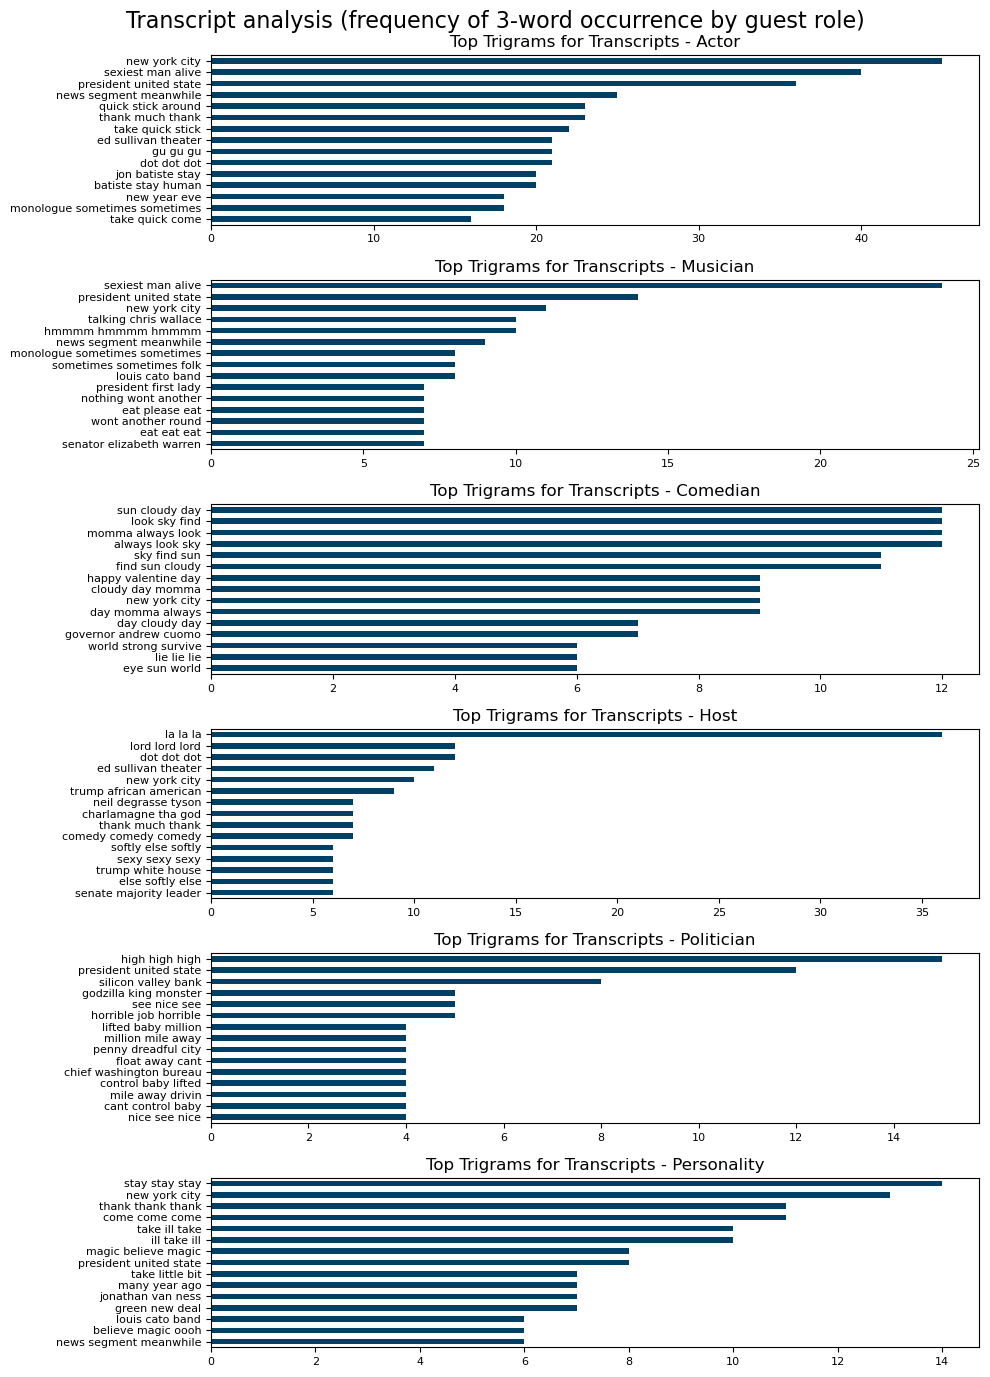

In [39]:
fig, axes = plt.subplots(6, 1, figsize=(10, 14), tight_layout=True)

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Actor"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Actor', color='#004065', fontsize=8, ax=axes[0])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Musician"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Musician', color='#004065', fontsize=8, ax=axes[1])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Comedian"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Comedian', color='#004065', fontsize=8, ax=axes[2])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Host"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Host', color='#004065', fontsize=8, ax=axes[3])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Politician"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Politician', color='#004065', fontsize=8, ax=axes[4])).invert_yaxis();

(transcripts_lemmed_[transcripts_lemmed_['occupation'] == "Personality"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Transcripts - Personality', color='#004065', fontsize=8, ax=axes[5])).invert_yaxis();



fig.suptitle('Transcript analysis (frequency of 3-word occurrence by guest role)', fontsize=16)
plt.savefig('transcript_by_role.jpg');

In [70]:
cvec_1 = CountVectorizer(ngram_range=(1, 1), stop_words=stops)
cvec_1.fit(colbtert_df_transcripts_lemmed)
cvec_transform_1 = cvec_1.transform(colbtert_df_transcripts_lemmed)
transcripts_lemmed_1 = pd.DataFrame(cvec_transform_1.todense(), columns=cvec_1.get_feature_names_out())

In [72]:
transcripts_lemmed_1 = transcripts_lemmed_1.drop(columns=["occupation"])

In [73]:
transcripts_lemmed_1 = pd.concat((transcripts_lemmed_1, mapped_df["occupation"]), axis=1)

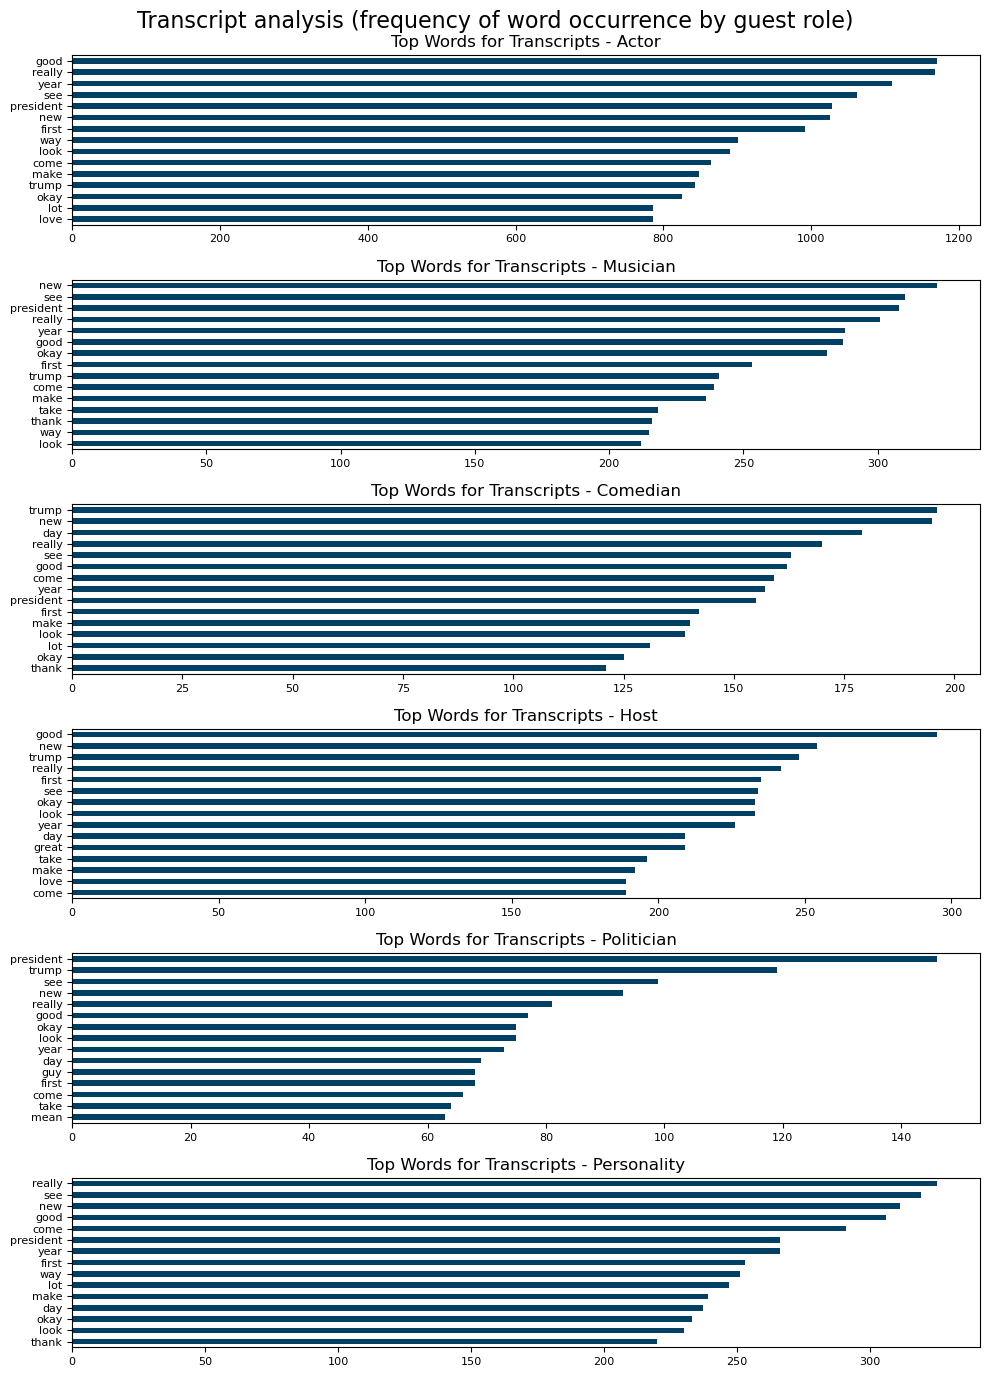

In [74]:
fig, axes_ = plt.subplots(6, 1, figsize=(10, 14), tight_layout=True)

(transcripts_lemmed_1[transcripts_lemmed_1['occupation'] == "Actor"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Words for Transcripts - Actor', color='#004065', fontsize=8, ax=axes_[0])).invert_yaxis();


(transcripts_lemmed_1[transcripts_lemmed_1['occupation'] == "Musician"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Words for Transcripts - Musician', color='#004065', fontsize=8, ax=axes_[1])).invert_yaxis();

(transcripts_lemmed_1[transcripts_lemmed_1['occupation'] == "Comedian"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Words for Transcripts - Comedian', color='#004065', fontsize=8, ax=axes_[2])).invert_yaxis();

(transcripts_lemmed_1[transcripts_lemmed_1['occupation'] == "Host"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Words for Transcripts - Host', color='#004065', fontsize=8, ax=axes_[3])).invert_yaxis();

(transcripts_lemmed_1[transcripts_lemmed_1['occupation'] == "Politician"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Words for Transcripts - Politician', color='#004065', fontsize=8, ax=axes_[4])).invert_yaxis();

(transcripts_lemmed_1[transcripts_lemmed_1['occupation'] == "Personality"]
    .drop(columns=['occupation'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Words for Transcripts - Personality', color='#004065', fontsize=8, ax=axes_[5])).invert_yaxis();


fig.suptitle('Transcript analysis (frequency of word occurrence by guest role)', fontsize=16)
plt.savefig('transcript_by_role_1.jpg');

In [ ]:
transcripts_df = pd.DataFrame(colbtert_df_transcripts_lemmed)

In [ ]:
tfidf = TfidfVectorizer()

In [75]:
vid_stats_1 = pd.read_pickle("vid_stats_1.pkl")
vid_stats_2 = pd.read_pickle("vid_stats_2.pkl")
vid_stats_3 = pd.read_pickle("vid_stats_3.pkl")
vid_stats_4 = pd.read_pickle("vid_stats_4.pkl")
vid_stats_5 = pd.read_pickle("vid_stats_5.pkl")
vid_stats_6 = pd.read_pickle("vid_stats_6.pkl")
vid_stats_7 = pd.read_pickle("vid_stats_7.pkl")
vid_stats_8 = pd.read_pickle("vid_stats_8.pkl")
vid_stats_9 = pd.read_pickle("vid_stats_9.pkl")
vid_stats_10 = pd.read_pickle("vid_stats_10.pkl")
vid_stats_11 = pd.read_pickle("vid_stats_11.pkl")

In [77]:
vid_stats_1

,video_id,video_views,video_likes,video_comments,video_duration
0,DFCPznfRnS8,71657,1961,400,PT4M6S
1,lrm3agZABVc,90220,1756,109,PT2M39S
2,eo1tRMs9SzA,290068,4263,289,PT6M44S
3,aFXuAHnaJvk,165761,3348,141,PT3M44S
4,WOg93THAyE0,162283,10450,599,PT4M7S
...,...,...,...,...,...
995,OfIciEYmHI8,769198,9258,983,PT4M12S
996,E6WRJUuOT0o,1305877,16030,1307,PT7M44S
997,9Kq7IwqWPJ4,1725742,33671,1782,PT10M41S
998,kwlsZom_7wg,82627,1130,64,PT8M9S


In [86]:
vid_stats_df_final = vid_stats_1._append([vid_stats_2,
                                            vid_stats_3,
                                            vid_stats_4,
                                            vid_stats_5,
                                            vid_stats_6,
                                            vid_stats_7,
                                            vid_stats_8,
                                            vid_stats_9,
                                            vid_stats_10,
                                            vid_stats_11], ignore_index=True)
vid_stats_df_final.to_csv("vids_statistics.csv")

In [79]:
vids_statistics=pd.read_csv("vids_statistics.csv",index_col=0)

In [83]:
vid_stats_1.shape

(1000, 5)

In [ ]:
vids_statistics["stats_ratio"]=vids_statistics["video_likes"]/vids_statistics["video_views"]